In [9]:
##############################################################################
# Copyright 2016-2017 Rigetti Computing
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.
##############################################################################

"""
Module for amplitude amplification, for use in algorithms such as Grover's algorithm.

 See G. Brassard, P. Hoyer, M. Mosca (2000) `Quantum Amplitude Amplification and Estimation
 <https://arxiv.org/abs/quant-ph/0005055>`_ for more information.
"""
from typing import Dict, List
import numpy as np
from pyquil import Program
from pyquil import get_qc
from pyquil.api import QuantumComputer
from pyquil.gates import H, X, Z, RZ, STANDARD_GATES, MEASURE
from grove.utils.utility_programs import ControlledProgramBuilder
from itertools import product
from pyquil.api import WavefunctionSimulator
import matplotlib.pyplot as plt


In [10]:
STANDARD_GATE_NAMES = list(STANDARD_GATES.keys())
X_GATE = np.array([[0, 1], [1, 0]])
X_GATE_LABEL = "NOT"
HADAMARD_DIFFUSION_LABEL = "HADAMARD_DIFFUSION"


def diffusion_program(qubits: List[int]) -> Program:
    diffusion_program = Program()
    dim = 2 ** len(qubits)
    hadamard_diffusion_matrix = np.diag([1.0] + [-1.0] * (dim - 1))
    diffusion_program.defgate(HADAMARD_DIFFUSION_LABEL, hadamard_diffusion_matrix)
    instruction_tuple = (HADAMARD_DIFFUSION_LABEL,) + tuple(qubits)
    diffusion_program.inst(instruction_tuple)
    return diffusion_program


def amplification_circuit(algorithm: Program, oracle: Program,
                          qubits: List[int],
                          num_iter: int,
                          decompose_diffusion: bool = False) -> Program:
    """
    Returns a program that does ``num_iter`` rounds of amplification, given a measurement-less
    algorithm, an oracle, and a list of qubits to operate on.

    :param algorithm: A program representing a measurement-less algorithm run on qubits.
    :param oracle: An oracle maps any basis vector ``|psi>`` to either ``+|psi>`` or
        ``-|psi>`` depending on whether ``|psi>`` is in the desirable subspace or the undesirable
        subspace.
    :param qubits: the qubits to operate on
    :param num_iter: number of iterations of amplifications to run
    :param decompose_diffusion: If True, decompose the Grover diffusion gate into two qubit
     gates. If False, use a defgate to define the gate.
    :return: The amplified algorithm.
    """
    program = Program()

    uniform_superimposer = Program().inst([H(qubit) for qubit in qubits])
    program += uniform_superimposer
    if decompose_diffusion:
        diffusion = decomposed_diffusion_program(qubits)
    else:
        diffusion = diffusion_program(qubits)
    # To avoid redefining gates, we collect them before building our program.
    defined_gates = oracle.defined_gates + algorithm.defined_gates + diffusion.defined_gates
    for _ in range(num_iter):
        program += (oracle.instructions
                 + algorithm.dagger().instructions
                 + diffusion.instructions
                 + algorithm.instructions)
    # We redefine the gates in the new program.
    for gate in defined_gates:
        program.defgate(gate.name, gate.matrix)
        
    return program


def decomposed_diffusion_program(qubits: List[int]) -> Program:
    """
    Constructs the diffusion operator used in Grover's Algorithm, acted on both sides by an
    a Hadamard gate on each qubit. Note that this means that the matrix representation of this
    operator is diag(1, -1, ..., -1). In particular, this decomposes the diffusion operator, which
    is a :math:`2**{len(qubits)}\times2**{len(qubits)}` sparse matrix, into
     :math:`\mathcal{O}(len(qubits)**2) single and two qubit gates.

    See C. Lavor, L.R.U. Manssur, and R. Portugal (2003) `Grover's Algorithm: Quantum Database
    Search`_ for more information.

    .. _`Grover's Algorithm: Quantum Database Search`: https://arxiv.org/abs/quant-ph/0301079

    :param qubits: A list of ints corresponding to the qubits to operate on.
                   The operator operates on bistrings of the form
                   ``|qubits[0], ..., qubits[-1]>``.
    """
    program = Program()
    if len(qubits) == 1:
        program.inst(Z(qubits[0]))
    else:
        program.inst([X(q) for q in qubits])
        program.inst(H(qubits[-1]))
        program.inst(RZ(-np.pi, qubits[0]))
        program += (ControlledProgramBuilder()
                              .with_controls(qubits[:-1])
                              .with_target(qubits[-1])
                              .with_operation(X_GATE)
                              .with_gate_name(X_GATE_LABEL).build())
        program.inst(RZ(-np.pi, qubits[0]))
        program.inst(H(qubits[-1]))
        program.inst([X(q) for q in qubits])
    return program

class Grover(object):
    """This class contains an implementation of Grover's algorithm using pyQuil. See `these notes`_
     by Dave Bacon for more information.

    .. _these notes: https://courses.cs.washington.edu/courses/cse599d/06wi/lecturenotes12.pdf
    """
    def diffusion_program(self, qubits: List[int]) -> Program:
        diffusion_program = Program()
        dim = 2 ** len(qubits)
        hadamard_diffusion_matrix = np.diag([1.0] + [-1.0] * (dim - 1))
        diffusion_program.defgate(HADAMARD_DIFFUSION_LABEL, hadamard_diffusion_matrix)
        instruction_tuple = (HADAMARD_DIFFUSION_LABEL,) + tuple(qubits)
        diffusion_program.inst(instruction_tuple)
        return diffusion_program
    def amplification_circuit(self, algorithm: Program, oracle: Program,
                          qubits: List[int],
                          num_iter: int,
                          decompose_diffusion: bool = False) -> Program:
        """
        Returns a program that does ``num_iter`` rounds of amplification, given a measurement-less
        algorithm, an oracle, and a list of qubits to operate on.

        :param algorithm: A program representing a measurement-less algorithm run on qubits.
        :param oracle: An oracle maps any basis vector ``|psi>`` to either ``+|psi>`` or
            ``-|psi>`` depending on whether ``|psi>`` is in the desirable subspace or the undesirable
            subspace.
        :param qubits: the qubits to operate on
        :param num_iter: number of iterations of amplifications to run
        :param decompose_diffusion: If True, decompose the Grover diffusion gate into two qubit
         gates. If False, use a defgate to define the gate.
        :return: The amplified algorithm.
        """
        program = Program()

        uniform_superimposer = Program().inst([H(qubit) for qubit in qubits])
        program += uniform_superimposer
        if decompose_diffusion:
            diffusion = decomposed_diffusion_program(qubits)
        else:
            diffusion = diffusion_program(qubits)
        # To avoid redefining gates, we collect them before building our program.
        defined_gates = oracle.defined_gates + algorithm.defined_gates + diffusion.defined_gates
        for _ in range(num_iter):
            program += (oracle.instructions
                     + algorithm.dagger().instructions
                     + diffusion.instructions
                     + algorithm.instructions)
        # We redefine the gates in the new program.
        for gate in defined_gates:
            program.defgate(gate.name, gate.matrix)

        return program
    
    def __init__(self, numIter):
        self.unitary_function_mapping = None
        self.n_qubits = None
        self.qubits = None
        self.grover_circuit = None
        self.bit_map = None
        self.numIter = numIter
        self.wfn = None

    @staticmethod
    def _compute_grover_oracle_matrix(bitstring_map: Dict[str, int]) -> np.ndarray:
        """
        Computes the unitary matrix that encodes the oracle function for Grover's algorithm

        :param bitstring_map: dict with string keys corresponding to bitstrings,
         and integer values corresponding to the desired phase on the output state.
        :return: a numpy array corresponding to the unitary matrix for oracle for the given
         bitstring_map
        """
        n_bits = len(list(bitstring_map.keys())[0])
        oracle_matrix = np.zeros(shape=(2 ** n_bits, 2 ** n_bits))
        for b in range(2 ** n_bits):
            pad_str = np.binary_repr(b, n_bits)
            phase_factor = bitstring_map[pad_str]
            oracle_matrix[b, b] = phase_factor
        return oracle_matrix

    def _construct_grover_circuit(self) -> None:
        """
        Constructs an instance of Grover's Algorithm, using initialized values.

        :return: None
        """
        oracle = Program()
        oracle_name = "GROVER_ORACLE"
        oracle.defgate(oracle_name, self.unitary_function_mapping)
        oracle.inst(tuple([oracle_name] + self.qubits))
        self.grover_circuit, self.wfn = self.oracle_grover(oracle, self.qubits, self.numIter)
        

    def _init_attr(self, bitstring_map: Dict[str, int]) -> None:
        """
        Initializes an instance of Grover's Algorithm given a bitstring_map.

        :param bitstring_map: dict with string keys corresponding to bitstrings, and integer
         values corresponding to the desired phase on the output state.
        :type bitstring_map: Dict[String, Int]
        :return: None
        """
        self.bit_map = bitstring_map
        self.unitary_function_mapping = self._compute_grover_oracle_matrix(bitstring_map)
        self.n_qubits = self.unitary_function_mapping.shape[0]
        self.qubits = list(range(int(np.log2(self.n_qubits))))
        self._construct_grover_circuit()
        

    def find_bitstring(self, qc: QuantumComputer, bitstring_map: Dict[str, int]) -> str:
        """
        Runs Grover's Algorithm to find the bitstring that is designated by ``bistring_map``.

        In particular, this will prepare an initial state in the uniform superposition over all bit-
        strings, an then use Grover's Algorithm to pick out the desired bitstring.

        :param qc: the connection to the Rigetti cloud to run pyQuil programs.
        :param bitstring_map: a mapping from bitstrings to the phases that the oracle should impart
            on them. If the oracle should "look" for a bitstring, it should have a ``-1``, otherwise
            it should have a ``1``.
        :return: Returns the bitstring resulting from measurement after Grover's Algorithm.
        """

        self._init_attr(bitstring_map)

        ro = self.grover_circuit.declare('ro', 'BIT', len(self.qubits))
        self.grover_circuit += [MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(self.qubits)]
        executable = qc.compile(self.grover_circuit)
        sampled_bitstring = qc.run(executable)

        return "".join([str(bit) for bit in sampled_bitstring[0]])

    @staticmethod
    def oracle_grover(oracle: Program, qubits: List[int], num_iter: int = None) -> Program:
        """
        Implementation of Grover's Algorithm for a given oracle.

        :param oracle: An oracle defined as a Program. It should send :math:`\ket{x}`
            to :math:`(-1)^{f(x)}\ket{x}`, where the range of f is {0, 1}.
        :param qubits: List of qubits for Grover's Algorithm.
        :param num_iter: The number of iterations to repeat the algorithm for.
                         The default is the integer closest to :math:`\frac{\pi}{4}\sqrt{N}`,
                         where :math:`N` is the size of the domain.
        :return: A program corresponding to the desired instance of Grover's Algorithm.
        """
        if num_iter is None:
            num_iter = int(round(np.pi * 2 ** (len(qubits) / 2.0 - 2.0)))
        uniform_superimposer = Program().inst([H(qubit) for qubit in qubits])
        amp_prog = amplification_circuit(uniform_superimposer, oracle, qubits, num_iter)
        #print(amp_prog)
        wfn = WavefunctionSimulator().wavefunction(amp_prog)
        
        return amp_prog, wfn

In [11]:
#target_string = "rip"
#target_bitstring = ' '.join(format(x, 'b') for x in bytearray(target_string,'utf8'))
target_bitstring = '00010'
bit = ("0", "1")
bitstring_map = {}
target_bitstring_phase = -1
nontarget_bitstring_phase = 1

# We construct the bitmap for the oracle
for bitstring in product(bit, repeat=len(target_bitstring)):
    #print(bitstring)
    bitstring = "".join(bitstring)
    print(bitstring)
    if bitstring == target_bitstring:
        bitstring_map[bitstring] = target_bitstring_phase
    else:
        bitstring_map[bitstring] = nontarget_bitstring_phase

00000
00001
00010
00011
00100
00101
00110
00111
01000
01001
01010
01011
01100
01101
01110
01111
10000
10001
10010
10011
10100
10101
10110
10111
11000
11001
11010
11011
11100
11101
11110
11111


In [12]:
target_bitstring_phase = -1
nontarget_bitstring_phase = 1
for k,v in bitstring_map.items():
    if k == target_bitstring:
        assert v == target_bitstring_phase, "The target bitstring has the wrong phase."
    else:
        assert v == nontarget_bitstring_phase, "A nontarget bistring has the wrong phase."

In [13]:
number_of_qubits = 8
qc = get_qc(f"{number_of_qubits}q-qvm")

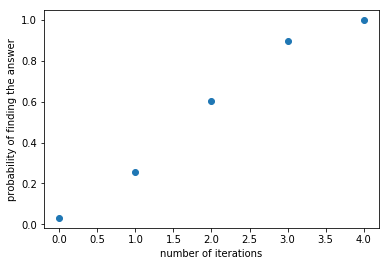

In [14]:
#grover = Grover(5)
#found_bitstring = grover.find_bitstring(qc, bitstring_map)
#assert found_bitstring == target_bitstring, "Found bitstring is not the expected bitstring"
#print(found_bitstring)
#print(grover.wfn)
iterations = []
PFind = []
answer = 8
for i in range(0,5):
    grover = Grover(i)
    found_bitstring = grover.find_bitstring(qc, bitstring_map)
    #print(found_bitstring)
    result = grover.wfn
    iterations.append(i)
    PFind.append(np.absolute(result[answer])**2)
    
plt.plot(iterations,PFind,'o')
plt.xlabel('number of iterations')
plt.ylabel('probability of finding the answer')
plt.show()
    

In [31]:
class PartialSearch(Grover):
    blockSize = 0
    def __init__(self, numIter, block_size):
        self.block_size = block_size
        self.unitary_function_mapping = None
        self.n_qubits = None
        self.qubits = None
        self.grover_circuit = None
        self.bit_map = None
        self.numIter = numIter
        self.wfn = None
    def block_diffusion_program(self, oracle: Program, qubits: List[int], block_size: int, num_iter: int = None) -> Program:
        """
        Updated diffusion_program for partial search
        """
        if num_iter is None:
            num_iter = int(round(np.pi * 2 ** (len(qubits) / 2.0 - 2.0)))
        assert block_size <= len(qubits), "Block size is bounded by total number of qubits"
        PARTIAL_DIFFUSION_LABEL = "PARTIAL_DIFFUSION"
        diffusion_program = Program()
        dim = 2 ** (len(qubits)/ num_iter)
        # setup diffusion matrix
        inverter = np.identity(dim)
        inverter[0,0] = -1
        partial_diffusion_matrix = np.kron(np.identity(2**block_size),inverter)
        diffusion_program.defgate(PARTIAL_DIFFUSION_LABEL, partial_diffusion_matrix)
        instruction_tuple = (PARTIAL_DIFFUSION_LABEL,) + tuple(qubits)
        partial_diffusion_progam.inst(instruction_tuple)
        return partial_diffusion_program
    def amplification_circuit(self, algorithm: Program, oracle: Program,
                          qubits: List[int],
                          num_iter: int,
                          decompose_diffusion: bool = False) -> Program:
        """
        Updated amplification circuit for partial search
        """
        program = Program()

        uniform_superimposer = Program().inst([H(qubit) for qubit in qubits])
        program += uniform_superimposer
        diffusion = self.block_diffusion_program(qubits,self.block_size)
        # To avoid redefining gates, we collect them before building our program.
        defined_gates = oracle.defined_gates + algorithm.defined_gates + diffusion.defined_gates
        for _ in range(num_iter//2):
            program += (oracle.instructions
                     + algorithm.dagger().instructions
                     + diffusion.instructions
                     + algorithm.instructions)
        for _ in range(num_iter//2):
            program += (oracle.instructions
                     + algorithm.dagger().instructions
                     + self.diffusion_program(qubits).instructions
                     + algorithm.instructions)
        # We redefine the gates in the new program.
        for gate in defined_gates:
            program.defgate(gate.name, gate.matrix)
        return program


00000
00001
00010
00011
00100
00101
00110
00111
01000
01001
01010
01011
01100
01101
01110
01111
10000
10001
10010
10011
10100
10101
10110
10111
11000
11001
11010
11011
11100
11101
11110
11111


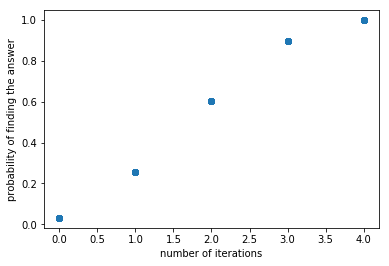

In [37]:
#target_string = "rip"
#target_bitstring = ' '.join(format(x, 'b') for x in bytearray(target_string,'utf8'))
target_bitstring = '00010'
bit = ("0", "1")
bitstring_map = {}
target_bitstring_phase = -1
nontarget_bitstring_phase = 1

# We construct the bitmap for the oracle
for bitstring in product(bit, repeat=len(target_bitstring)):
    #print(bitstring)
    bitstring = "".join(bitstring)
    print(bitstring)
    if bitstring == target_bitstring:
        bitstring_map[bitstring] = target_bitstring_phase
    else:
        bitstring_map[bitstring] = nontarget_bitstring_phase

target_bitstring_phase = -1
nontarget_bitstring_phase = 1
for k,v in bitstring_map.items():
    if k == target_bitstring:
        assert v == target_bitstring_phase, "The target bitstring has the wrong phase."
    else:
        assert v == nontarget_bitstring_phase, "A nontarget bistring has the wrong phase."
number_of_qubits = 8
qc = get_qc(f"{number_of_qubits}q-qvm")
for i in range(0,5):
    grover = PartialSearch(i,3)
    found_bitstring = grover.find_bitstring(qc, bitstring_map)
    #print(found_bitstring)
    result = grover.wfn
    iterations.append(i)
    PFind.append(np.absolute(result[answer])**2)
    
plt.plot(iterations,PFind,'o')
plt.xlabel('number of iterations')
plt.ylabel('probability of finding the answer')
plt.show()